### position별 EDA
#### 1. minutes 히스토그램 및 박스플롯 확인 -> 3사분위수 이하 제거 (비주전 선수 영향 최소화)
#### 2. 변수별 기초통계량 확인 
#### 3. 변수별 분포 및 상관관계 확인 -> 각 포지션별로 상관이 높은 변수 삭제 혹은 전처리 필요

### 전처리
#### 1. 포지션별 불필요한 변수 제거
#### 2. 파생변수 생성 패스 성공률 관련 변수 추가
#### 3. 패스 관련 변수를 minutes/90 으로 나눠주기 

### PCA 실시
#### 1. 분산 설명력, 고유벡터 확인
#### 2. 시각화 및 인사이트 도출 

In [2]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

C:\Users\user\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [1]:
import pandas as pd 
import numpy as np

In [4]:
#그래프 출력 조건

# minus font 
# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
mpl.rcParams['axes.unicode_minus'] = False 

# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline

# customize matplitlib
plt.rcParams["figure.figsize"] = (25,10)
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['font.size'] = 10

In [2]:
df = pd.read_csv("D:/경기대/2학년_2학기/dna 동아리/23_겨울방학프로젝트/전처리csv/worldcup_passing.csv", encoding='utf-8')

In [81]:
df.head()

,player,position,team,age,birth_year,minutes,round,passes_completed,passes,passes_total_distance,...,passes_completed_medium,passes_medium,passes_completed_long,passes_long,assists,assisted_shots,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,progressive_passes
0,Andrej Kramarić,FW,Croatia,31,1991,477,semi finals,153,176,2049,...,35,38,7,12,0,4,0,3,1,4
1,Ante Budimir,FW,Croatia,31,1991,54,semi finals,2,5,12,...,0,2,0,0,0,1,0,0,0,0
2,Borna Barišić,DF,Croatia,30,1992,117,semi finals,50,69,818,...,19,27,5,11,0,1,2,4,3,3
3,Borna Sosa,DF,Croatia,24,1998,423,semi finals,220,278,3068,...,61,83,10,23,0,2,11,3,2,9
4,Bruno Petković,FW,Croatia,28,1994,234,semi finals,40,75,590,...,10,17,4,8,0,4,7,0,0,5


#### 포지션별 출전시간 산점도 확인

In [234]:
def position_plot(n,df): #자기 포지션에 맞는 n번호 입력 
    
    if n == 1:
        df = df[df['position']=='GK']
    elif n == 2:
        df = df[df['position']=='DF']
    elif n == 3:
        df = df[df['position']=='MF']
    elif n == 4:
        df = df[df['position']=='FW']
    
    return(plt.boxplot(df['minutes']))

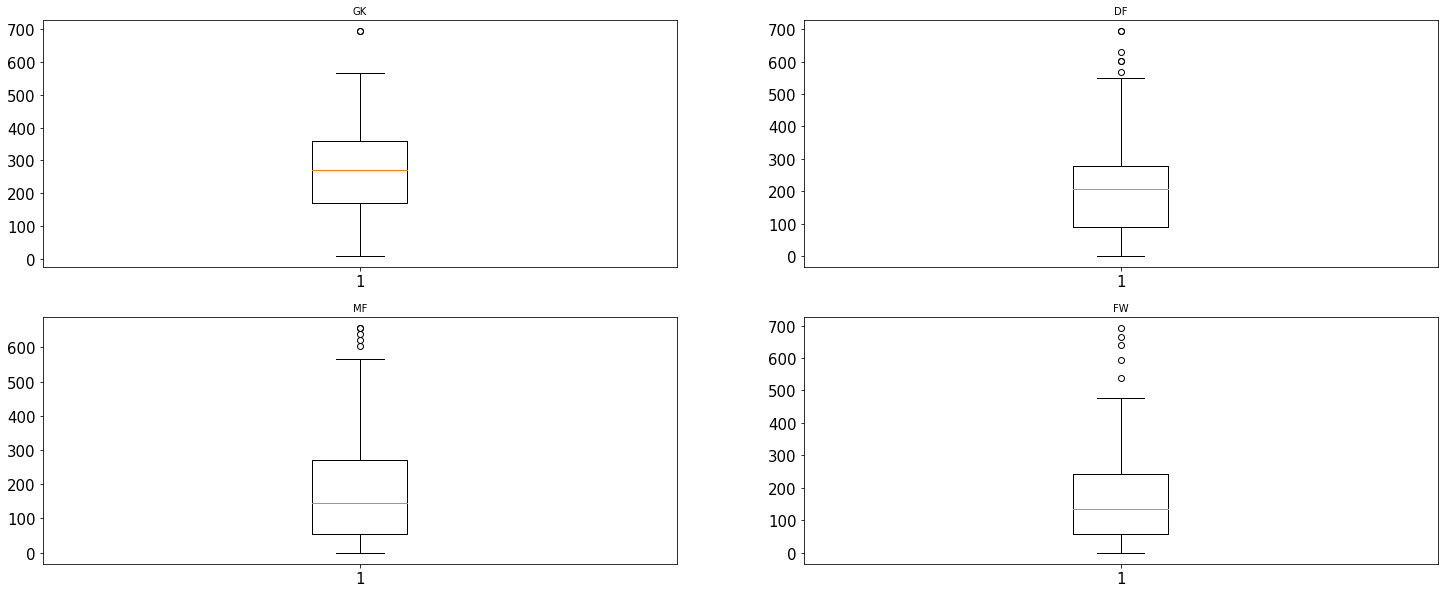

In [235]:
position = ['GK','DF','MF','FW']

for i in range(len(position)):
    plt.subplot(2, 2, i+1)
    position_plot(i+1,df)
    plt.title(position[i], fontsize=10)

#### 사전 분포 확인

In [43]:
#자신이 보고자 하는 position 확인

df_eda = df[df['position'] == 'MF']
df_eda = df_eda.drop(columns=['player','position','team','age','birth_year','round'],axis=1)

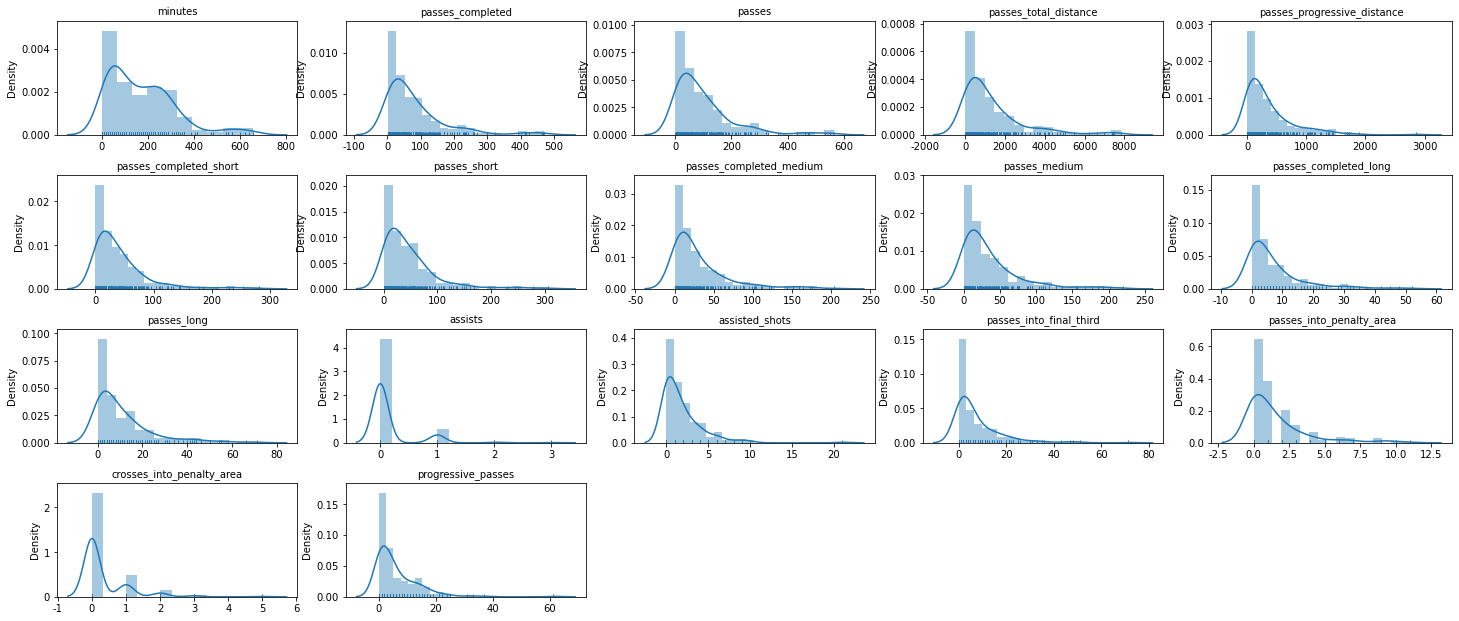

In [44]:
import warnings
warnings.filterwarnings( 'ignore' )

plt.figure(figsize=(25, 10)) # 가로, 세로 
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35) #서브플롯 간 간격 조정

for i in range(len(df_eda.columns)):
  col = df_eda.columns[i]

  plt.subplot(4, 5, i+1)
  sns.distplot(x=df_eda[col], kde=True, rug=True)
  plt.title(col, fontsize=10)

### 사전 전처리
#### -패스 관련 변수를 분당 패스로 나눠줌 
#### -성공률 관련 변수 생성

In [3]:
def pca_data(df,n):
    
    #패스 성공률 변수 생성
    passes_pct = round(df.loc[:,'passes_completed'] / df.loc[:,'passes'],2)
    passes_pct = pd.DataFrame(passes_pct, columns=['passes_pct'])
    df['passes_pct'] = passes_pct

    #롱패스 성공률 변수 생성
    long_passes_pct = round(df.loc[:,'passes_completed_long'] / df.loc[:,'passes_long'],2)
    long_passes_pct = pd.DataFrame(long_passes_pct, columns=['long_passes_pct'])
    df['long_passes_pct'] = long_passes_pct
    
    #미디움 패스 성공률 변수 생성
    medium_passes_pct = round(df.loc[:,'passes_completed_medium'] / df.loc[:,'passes_medium'],2)
    medium_passes_pct = pd.DataFrame(medium_passes_pct, columns=['medium_passes_pct'])
    df['medium_passes_pct'] = medium_passes_pct
    
    def function(n):
        #분당패스로 나눠주기
        df.iloc[:,n] = round(df.iloc[:,n]/(df['minutes']/90),1)

        #n은 7부터 21까지가 필요한 변수이므로 7~23까지만 function 적용
    for i in range(n,23):
        function(i)

    #패스 성공(성공률 아님!) 관련 변수 삭제     
    df = df[df.columns.drop(list(df.filter(regex='completed')))]
    #df = df.drop(columns=['assists', 'assisted_shots', 'passes_into_penalty_area', 'crosses_into_penalty_area'])
    
    return(df)

In [4]:
df = pca_data(df,7)
df.head(5)

,player,position,team,age,birth_year,minutes,round,passes,passes_total_distance,passes_progressive_distance,...,passes_long,assists,assisted_shots,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,progressive_passes,passes_pct,long_passes_pct,medium_passes_pct
0,Andrej Kramarić,FW,Croatia,31,1991,477,semi finals,33.2,386.6,44.0,...,2.3,0.0,0.8,0.0,0.6,0.2,0.8,0.87,0.58,0.92
1,Ante Budimir,FW,Croatia,31,1991,54,semi finals,8.3,20.0,0.0,...,0.0,0.0,1.7,0.0,0.0,0.0,0.0,0.40,NaN,0.00
2,Borna Barišić,DF,Croatia,30,1992,117,semi finals,53.1,629.2,223.1,...,8.5,0.0,0.8,1.5,3.1,2.3,2.3,0.72,0.45,0.70
3,Borna Sosa,DF,Croatia,24,1998,423,semi finals,59.1,652.8,238.9,...,4.9,0.0,0.4,2.3,0.6,0.4,1.9,0.79,0.43,0.73
4,Bruno Petković,FW,Croatia,28,1994,234,semi finals,28.8,226.9,45.8,...,3.1,0.0,1.5,2.7,0.0,0.0,1.9,0.53,0.50,0.59


#### 밑에 def랑 for문은 공부하라고 넣은거!

In [74]:
#분당 패스 성공을 나눈 로직 
#def function(df,n):
    #df.iloc[:,n] = round(df.iloc[:,n]/(df['minutes']/90),1)
    
    #return(df)

#n값에 시작할 열 번호지정
#for i in range(7,21): #21인 이유는 22,23번은 성공률에 대한 것이므로 
    #function(df,i)

#### 변수별 분포 확인

#### -포지션별 출전시간 이상치 제거 및 분포 재확인 

In [83]:
#포지션별 minutes 특정 사분위 제거 함수

def position_eda(n,df): #자기 포지션에 맞는 n번호 입력 
    
    if n == 1:
        df = df[df['position']=='GK']
    elif n == 2:
        df = df[df['position']=='DF']
    elif n == 3:
        df = df[df['position']=='MF']
    elif n == 4:
        df = df[df['position']=='FW']
    
    q1,q2,q3 = np.percentile(df['minutes'], [25,50,75]) #1,2,3사분위수
    iqr = q3-q1 
    lower_bound = q1 - (iqr * 1.5) #1사분위 이하 이상치
    upper_bound = q3 + (iqr * 1.5) #3사분위 이하 이상치
    middle_bound = q2 #중앙값
    
    df = df[df['minutes'] > q1] #여기에 원하는 분위수 넣으면됨 나는 이상치 넣은거 
    
    return(df) 

#### 반드시 함수에 넣은 값을 저장할 것!!!

In [84]:
df = position_eda(3,df)

# 인덱스 재정렬
df = df.reset_index(drop=True)
df.head(5)

,player,position,team,age,birth_year,minutes,round,passes_completed,passes,passes_total_distance,...,passes_completed_medium,passes_medium,passes_completed_long,passes_long,assists,assisted_shots,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,progressive_passes
0,Lovro Majer,MF,Croatia,24,1998,126,semi finals,78,98,1165,...,27,34,3,8,0,2,5,4,3,5
1,Luka Modrić,MF,Croatia,37,1985,657,semi finals,465,551,7825,...,173,202,45,71,0,6,51,10,3,61
2,Marcelo Brozović,MF,Croatia,30,1992,549,semi finals,466,530,7429,...,151,167,48,54,0,5,31,1,0,25
3,Mateo Kovačić,MF,Croatia,28,1994,639,semi finals,415,460,6213,...,144,156,21,31,0,9,47,7,0,31
4,Abdelhamid Sabiri,MF,Morocco,26,1996,180,semi finals,45,58,690,...,7,13,7,10,1,3,3,0,0,0


In [57]:
#전처리 과정에서 생긴 오류 확인을 위해 결측치 확인 및 대체
#성공률에 결측치 존재 -> 성공/시도인데 성공이 없으면 0인데 nan으로 표현되므로 0으로 대체 
df.isnull().sum()

player                         0
position                       0
team                           0
age                            0
birth_year                     0
minutes                        0
round                          0
passes_completed               0
passes                         0
passes_total_distance          0
passes_progressive_distance    0
passes_completed_short         0
passes_short                   0
passes_completed_medium        0
passes_medium                  0
passes_completed_long          0
passes_long                    0
assists                        0
assisted_shots                 0
passes_into_final_third        0
passes_into_penalty_area       0
crosses_into_penalty_area      0
progressive_passes             0
dtype: int64

In [58]:
df = df.fillna(0)
df = df.replace([np.inf, -np.inf], 0) #inf값을 nan으로 대체 후 0으로 처리 

In [100]:
df_eda = df.drop(columns=['player','position','team','age','birth_year','round','minutes'],axis=1)

# 열별로 scaling 

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scale = pd.DataFrame(scaler.fit_transform(df_eda), columns=df_eda.columns, index = df_eda.index)

In [5]:
df_eda = df.drop(columns=['player','position','team','age','birth_year','round','minutes'],axis=1)
df_eda

,passes,passes_total_distance,passes_progressive_distance,passes_short,passes_medium,passes_long,assists,assisted_shots,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,progressive_passes,passes_pct,long_passes_pct,medium_passes_pct
0,33.2,386.6,44.0,20.9,7.2,2.3,0.0,0.8,0.0,0.6,0.2,0.8,0.87,0.58,0.92
1,8.3,20.0,0.0,1.7,3.3,0.0,0.0,1.7,0.0,0.0,0.0,0.0,0.40,NaN,0.00
2,53.1,629.2,223.1,20.0,20.8,8.5,0.0,0.8,1.5,3.1,2.3,2.3,0.72,0.45,0.70
3,59.1,652.8,238.9,32.8,17.7,4.9,0.0,0.4,2.3,0.6,0.4,1.9,0.79,0.43,0.73
4,28.8,226.9,45.8,13.1,6.5,3.1,0.0,1.5,2.7,0.0,0.0,1.9,0.53,0.50,0.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,49.3,884.0,253.1,14.7,27.9,6.6,0.0,0.0,3.4,0.0,0.0,0.9,0.90,0.61,0.96
673,31.0,414.0,303.0,2.0,15.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.61,0.14,1.00
674,60.5,834.3,240.5,30.2,21.2,7.0,0.4,2.0,4.1,1.2,0.9,2.9,0.85,0.64,0.88
675,123.3,2133.3,723.3,40.0,80.0,3.3,0.0,3.3,6.7,0.0,0.0,3.3,1.00,1.00,1.00


In [12]:
df_eda = df_eda.fillna(0)
df_eda = df_eda.replace([np.inf, -np.inf], 0) 

In [13]:
pca = PCA(n_components=15) #분은 2개로 해야 2차원 산점도로 표현 쉬움
printcipalComponents = pca.fit_transform(df_eda)

principalDf = pd.DataFrame(data=printcipalComponents, 
                           columns = [f"pca{num+1}" for num in range(15)])
# 주성분으로 이루어진 데이터 프레임 구성

In [14]:
print('각 주성분의 설명력:', pca.explained_variance_)
print('주성분의 기여율:', pca.explained_variance_ratio_)
print('전체 분산에 대한 기여율:',sum(pca.explained_variance_ratio_))

각 주성분의 설명력: [1.99863571e+05 8.57811279e+03 1.28402447e+02 3.41930873e+01
 2.02988779e+01 5.65909450e+00 4.23770187e+00 1.77159850e+00
 8.80551793e-01 6.36929118e-01 2.34561898e-01 6.65555599e-02
 3.70173489e-02 3.59253252e-02 5.95743838e-03]
주성분의 기여율: [9.57943581e-01 4.11147867e-02 6.15431313e-04 1.63887037e-04
 9.72922664e-05 2.71239688e-05 2.03112518e-05 8.49124931e-06
 4.22047367e-06 3.05279325e-06 1.12425223e-06 3.18999962e-07
 1.77423688e-07 1.72189632e-07 2.85539272e-08]
전체 분산에 대한 기여율: 0.9999999999999998


### 출전시간이 적은 선수 (1사분위수 이하), 필요없는 변수 제거, 표준화 변환 후 분포도

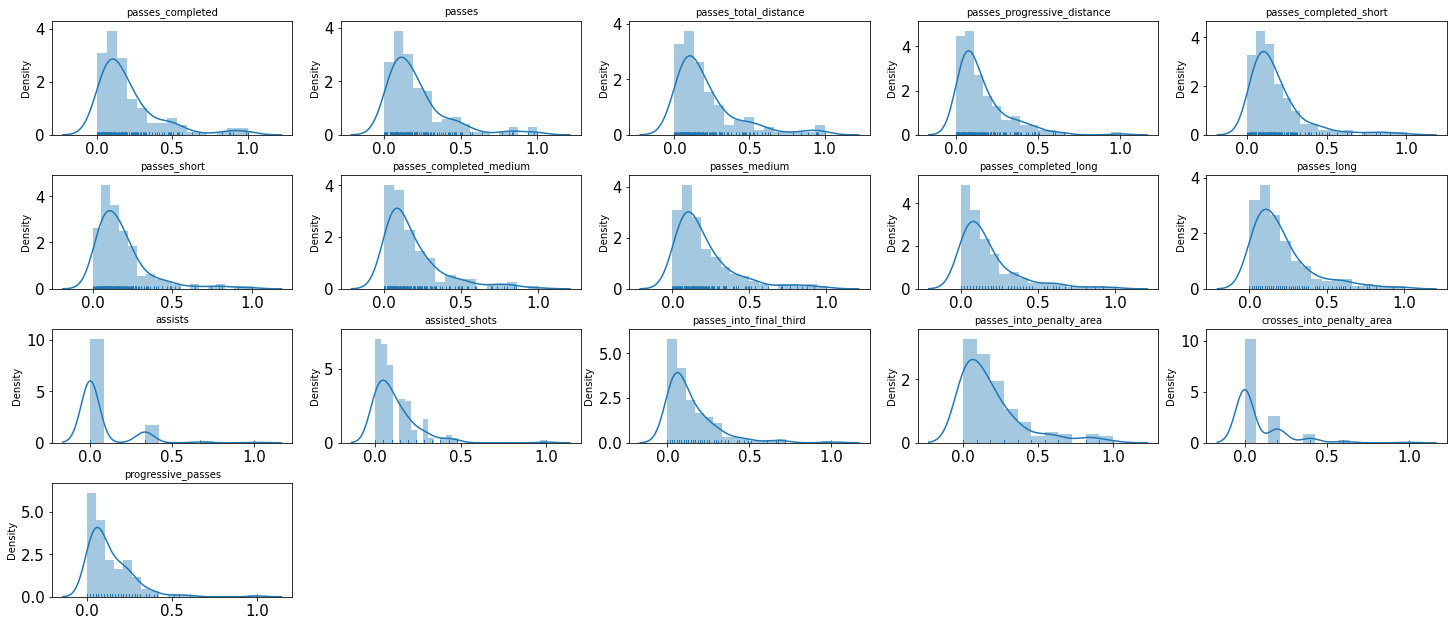

In [60]:
#변수별 분포 재확인
import warnings
warnings.filterwarnings( 'ignore' )

plt.figure(figsize=(25, 10)) # 가로, 세로 
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35) #서브플롯 간 간격 조정

for i in range(len(df_scale.columns)):
  col = df_scale.columns[i]

  plt.subplot(4, 5, i+1)
  sns.distplot(x=df_scale[col], kde=True, rug=True)
  plt.title(col, fontsize=10)

#### assist 관련 변수 무의미 -> 제거
#### medium_passes_pct 변수 거의 1에 머무름 -> 제거
#### crosses_into_penalty_area 변수 거의 0~0.25에 머무름 -> 제거 

In [87]:
df_scale.columns

Index(['passes_completed', 'passes', 'passes_total_distance',
       'passes_progressive_distance', 'passes_completed_short', 'passes_short',
       'passes_completed_medium', 'passes_medium', 'passes_completed_long',
       'passes_long', 'assists', 'assisted_shots', 'passes_into_final_third',
       'passes_into_penalty_area', 'crosses_into_penalty_area',
       'progressive_passes'],
      dtype='object')

In [16]:
#df_scale = df_scale.drop(columns=['assists','assisted_shots','medium_passes_pct','crosses_into_penalty_area'])

<AxesSubplot:title={'center':'pass_type'}>

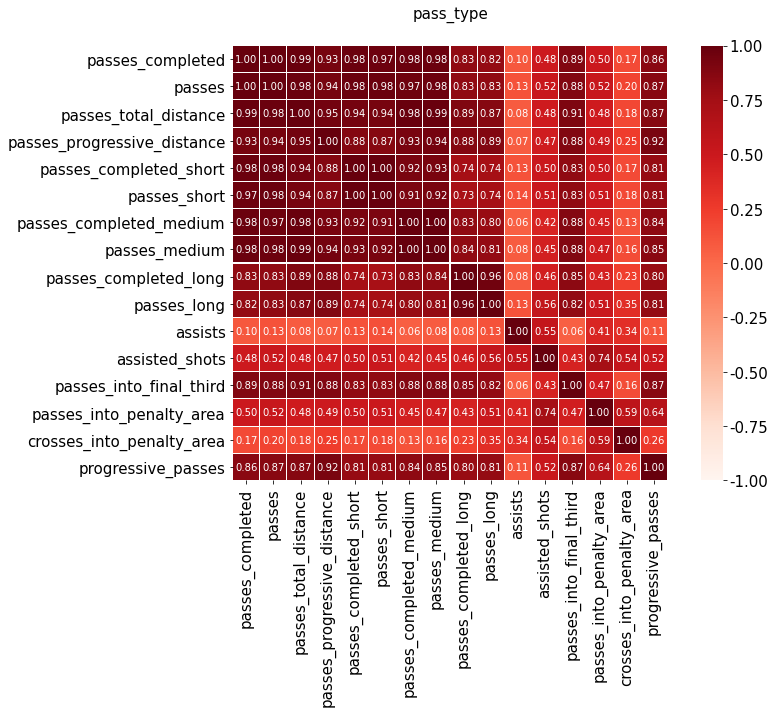

In [86]:
# 상관관계 히트맵 확인

plt.figure(figsize=(12, 8))
plt.title("pass_type", y = 1.05, size = 15)

sns.heatmap(df_scale.corr(), 
            linewidths = 0.1, #셀 사이 선을 집어넣음 
            vmax = 1.0, #최댓값 
            vmin = -1.0, #최솟값 
            square = True, 
            cmap = 'Reds',#맵 색깔
            linecolor = "white", #셀 사이 라인 색깔 
            annot = True, #각 셀의 표기 유무 및 그 값의 데이터타입 설정 
            fmt = '.2f', #각 셀의 값의 데이터 형태 (만약 소수2째자리까지 한다면 '.2f')
            annot_kws = {"size" : 10} #셀 안의 폰트 크기
           )

#### passes_total_distance 변수가 많은 변수와 높은 상관 -> 제거

In [101]:
df_scale = df_scale.drop(columns=['passes_total_distance','passes_progressive_distance'])

In [102]:
df_scale.shape

(165, 14)

### PCA 분석

### 사이킷런 라이브러리를 이용한 pca 구하기

In [6]:
from sklearn.decomposition import PCA

C:\Users\user\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [103]:
#표준화는 위에서 함 

# 고윳값을 기준으로 설명할 수 있는 분산량
pca = PCA(n_components=2) #주성분은 2개로 해야 2차원 산점도로 표현 쉬움
printcipalComponents = pca.fit_transform(df_scale)

principalDf = pd.DataFrame(data=printcipalComponents, columns = ['pca1', 'pca2'])
# 주성분으로 이루어진 데이터 프레임 구성

In [209]:
#pca = PCA(n_components=7) #주성분은 2개로 해야 2차원 산점도로 표현 쉬움
#printcipalComponents = pca.fit_transform(df_scale)

#principalDf = pd.DataFrame(data=printcipalComponents, 
#                           columns = [f"pca{num+1}" for num in range(7)])
# 주성분으로 이루어진 데이터 프레임 구성

#### 고윳값 (설명력)

In [104]:
print('각 주성분의 설명력:', pca.explained_variance_)
print('주성분의 기여율:', pca.explained_variance_ratio_)
print('전체 분산에 대한 기여율:',sum(pca.explained_variance_ratio_))

각 주성분의 설명력: [0.32038531 0.05700673]
주성분의 기여율: [0.72325098 0.12868933]
전체 분산에 대한 기여율: 0.8519403142920019


#### 기여율 = 특정 주성분의 부산 비율 = 특정 고윳값의 비율 = 특정 주성분 고윳값/ 모든 주성분의 고윳값합

In [105]:
pca_data = pd.DataFrame({'고윳값': pca.explained_variance_,
                        '기여율': pca.explained_variance_ratio_},
                       index=np.array([f"pca{num+1}" for num in range(2)]))
pca_data['누적 기여율'] = pca_data['기여율'].cumsum()
pca_data

,고윳값,기여율,누적 기여율
pca1,0.320385,0.723251,0.723251
pca2,0.057007,0.128689,0.851940


#### 고유벡터 (eigenvector)

In [106]:
print('pca1의 고유벡터:', np.round(pca.components_[0],3), sep = '\n')
print('                                    ')
print('pca2의 고유벡터', np.round(pca.components_[1],3) , sep= '\n')

pca1의 고유벡터:
[0.362 0.344 0.291 0.287 0.327 0.333 0.3   0.301 0.047 0.134 0.248 0.23
 0.078 0.213]
                                    
pca2의 고유벡터
[-0.129 -0.085 -0.081 -0.07  -0.164 -0.137 -0.069  0.031  0.419  0.342
 -0.087  0.624  0.472  0.028]


#### 각 변수별로 pca1,2에 어떤 영향을 주고 있는지 확인을 위해 데이터프레임화

In [107]:
a = np.round(pca.components_[0],3)
a = a.tolist()
b = np.round(pca.components_[1],3)
b = b.tolist()

In [108]:
pca_data = {'pca1' : a, 'pca2' : b}
df_pca = pd.DataFrame(pca_data, index= df_scale.columns)
df_pca

#minutes 변수 빼야함!

,pca1,pca2
passes_completed,0.362,-0.129
passes,0.344,-0.085
passes_completed_short,0.291,-0.081
passes_short,0.287,-0.070
passes_completed_medium,0.327,-0.164
passes_medium,0.333,-0.137
passes_completed_long,0.300,-0.069
passes_long,0.301,0.031
assists,0.047,0.419
assisted_shots,0.134,0.342


In [109]:
df_pca = df_pca.reset_index()

index = df_pca['index']
pca1 = df_pca['pca1']
pca2 = df_pca['pca2']

<BarContainer object of 14 artists>

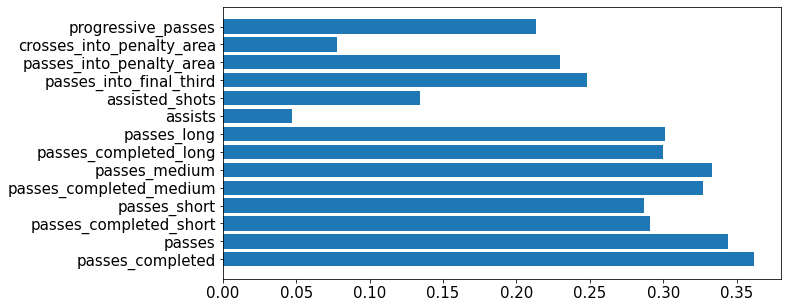

In [110]:
plt.figure(figsize=(10, 5))
plt.barh(index,pca1,label='pca1')

<BarContainer object of 15 artists>

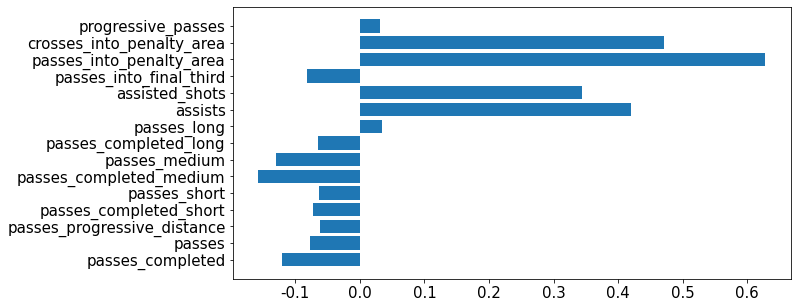

In [98]:
plt.figure(figsize=(10, 5))
plt.barh(index,pca2,label='pca2')

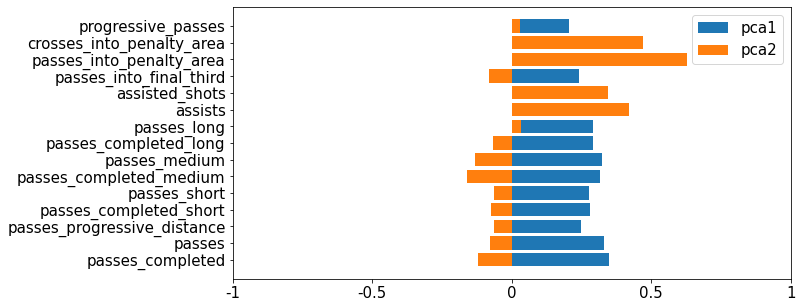

In [99]:
plt.figure(figsize=(10, 5))
plt.rcParams['font.size'] = 15
plt.barh(index,pca1,label='pca1')
plt.barh(index,pca2,label='pca2')
plt.xticks([-1,-0.5,0,0.5,1],('-1','-0.5','0','0.5','1'))
plt.legend()
plt.show()

#### 원본 데이터의 범주형 변수와 pca1, 2 병합

In [111]:
df_info1 = df.iloc[:,0:3] 
df_info2 = df.iloc[:,5:7]
df_col = df.iloc[:,7:]

result1 = pd.concat([df_info1, df_info2], axis=1)
result2 = pd.concat([result1, principalDf], axis=1)
result = pd.concat([result2,df_col], axis=1)

In [112]:
result.sort_values(by='pca1',ascending=False).head(5)

,player,position,team,minutes,round,pca1,pca2,passes_completed,passes,passes_total_distance,...,passes_completed_medium,passes_medium,passes_completed_long,passes_long,assists,assisted_shots,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,progressive_passes
1,Luka Modrić,MF,Croatia,657,semi finals,2.357580,0.220750,465,551,7825,...,173,202,45,71,0,6,51,10,3,61
42,Pedri,MF,Spain,360,round of 16,1.881186,-0.273211,393,434,7400,...,175,185,52,58,0,5,71,6,0,33
158,Rodrigo De Paul,MF,Argentina,603,finals,1.862641,-0.119862,470,562,6959,...,164,192,18,38,0,7,35,7,1,18
2,Marcelo Brozović,MF,Croatia,549,semi finals,1.822883,-0.565093,466,530,7429,...,151,167,48,54,0,5,31,1,0,25
155,Enzo Fernández,MF,Argentina,567,finals,1.785426,0.176909,412,471,6634,...,159,177,32,44,1,6,43,9,1,24


In [113]:
result.sort_values(by='pca2',ascending=False).head(5)

,player,position,team,minutes,round,pca1,pca2,passes_completed,passes,passes_total_distance,...,passes_completed_medium,passes_medium,passes_completed_long,passes_long,assists,assisted_shots,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,progressive_passes
161,Antoine Griezmann,MF,France,540,finals,1.468070,1.359516,258,329,4905,...,89,112,42,66,3,21,26,10,5,19
159,Ángel Di María,MF,Argentina,288,finals,0.428256,0.983038,130,168,2080,...,43,53,10,23,1,10,3,11,3,17
134,Dušan Tadić,MF,Serbia,261,group stage,0.207234,0.956326,90,127,1402,...,31,40,6,17,2,10,8,9,2,14
106,Jamal Musiala,MF,Germany,261,group stage,-0.033546,0.593313,85,105,1130,...,27,31,3,3,1,8,2,7,1,9
56,Lucas Paquetá,MF,Brazil,315,quarter finals,0.488801,0.536664,169,202,2578,...,69,77,10,15,1,6,16,9,1,15


### PCA 결과 시각화 및 인사이트 도출

#### 1. 사분면별로 그룹지어서 인사이트 도출
#### 2. 16강 진출한 국가와 탈락한 국가 그룹 지어 인사이트 도출
#### 3. 사분면별, 국가별로 골키퍼의 패스 특징에는 차이가 있다 없다로 ANOVA

In [15]:
result.corr()

NameError: name 'result' is not defined

<Figure size 1080x720 with 0 Axes>

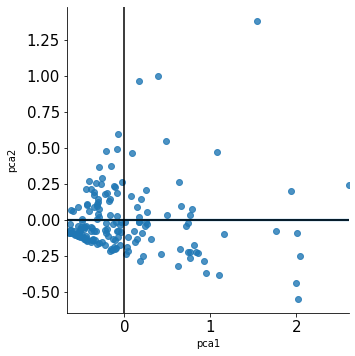

In [74]:
plt.figure(figsize=(15, 10))

sns.lmplot(x="pca1", y="pca2", height=5,data=result, ci=None) #height는 이미지 사이즈
plt.axvline(x=0, color = 'black') 
plt.axhline(y=0, color = 'black')
plt.show()

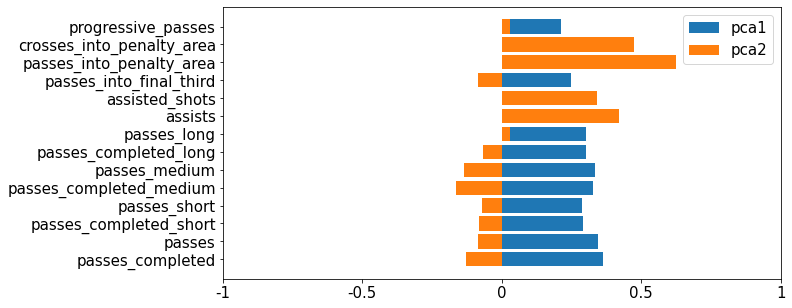

In [119]:
plt.figure(figsize=(10, 5))
plt.rcParams['font.size'] = 15
plt.barh(index,pca1,label='pca1')
plt.barh(index,pca2,label='pca2')
plt.xticks([-1,-0.5,0,0.5,1],('-1','-0.5','0','0.5','1'))
plt.legend()
plt.show()

#### pca1: 패스 성공률, 롱패스 성공률, 중간패스시도, 숏패스 시도가 많음, 롱패스 시도가 적음
#### pca2: 패스 시도, 파이널 서드 패스, 롱패스 시도가 많음

<Figure size 1440x720 with 0 Axes>

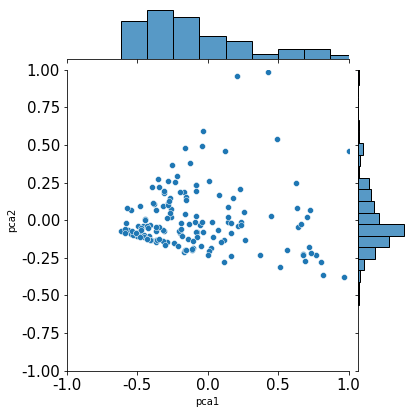

In [114]:
plt.figure(figsize=(20, 10))

sns.jointplot(x='pca1', y='pca2', data=result, xlim = (-1,1), ylim = (-1,1))
plt.show()

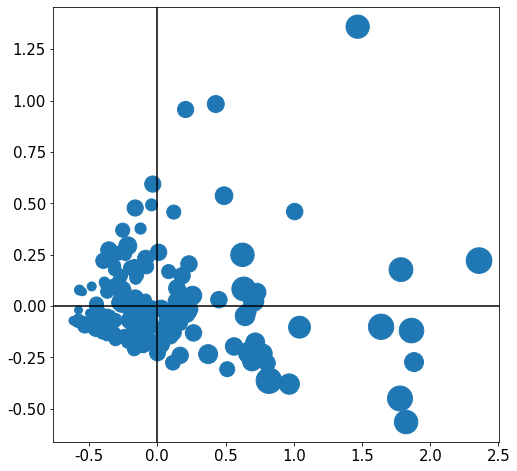

In [115]:
plt.figure(figsize=(8, 8))

plt.scatter(result['pca1'], result['pca2'],s=result['minutes'])
plt.axvline(x=0, color = 'black') 
plt.axhline(y=0, color = 'black')

In [94]:
pca1_pos = result['pca1']>=0
pca1_neg = result['pca1']<0
pca2_pos = result['pca2']>=0
pca2_neg = result['pca2']<0

In [95]:
pca_1 = result[pca1_pos & pca2_pos] #1사분면
pca_2 = result[pca1_neg & pca2_pos] #2사분면
pca_3 = result[pca1_neg & pca2_neg] #3사분면
pca_4 = result[pca1_pos & pca2_neg] #4사분면

In [116]:
result['round'].value_counts()

group stage       20
round of 16        9
quarter finals     6
finals             3
semi finals        3
Name: round, dtype: int64

In [116]:
#16강 유무 변환
result['round16'] = np.where(result['round'] == 'group stage',
                            'fail',
                            'sucess')

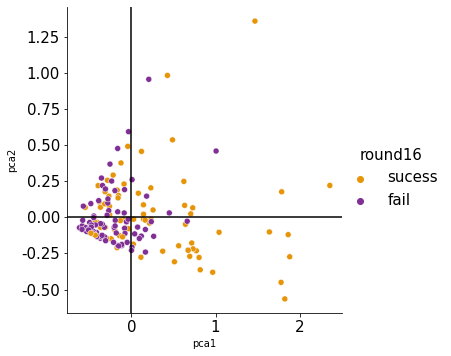

In [117]:
sns.relplot(x='pca1', y='pca2', hue='round16', data=result, palette='CMRmap_r')
plt.axvline(x=0, color = 'black') 
plt.axhline(y=0, color = 'black')
plt.show()

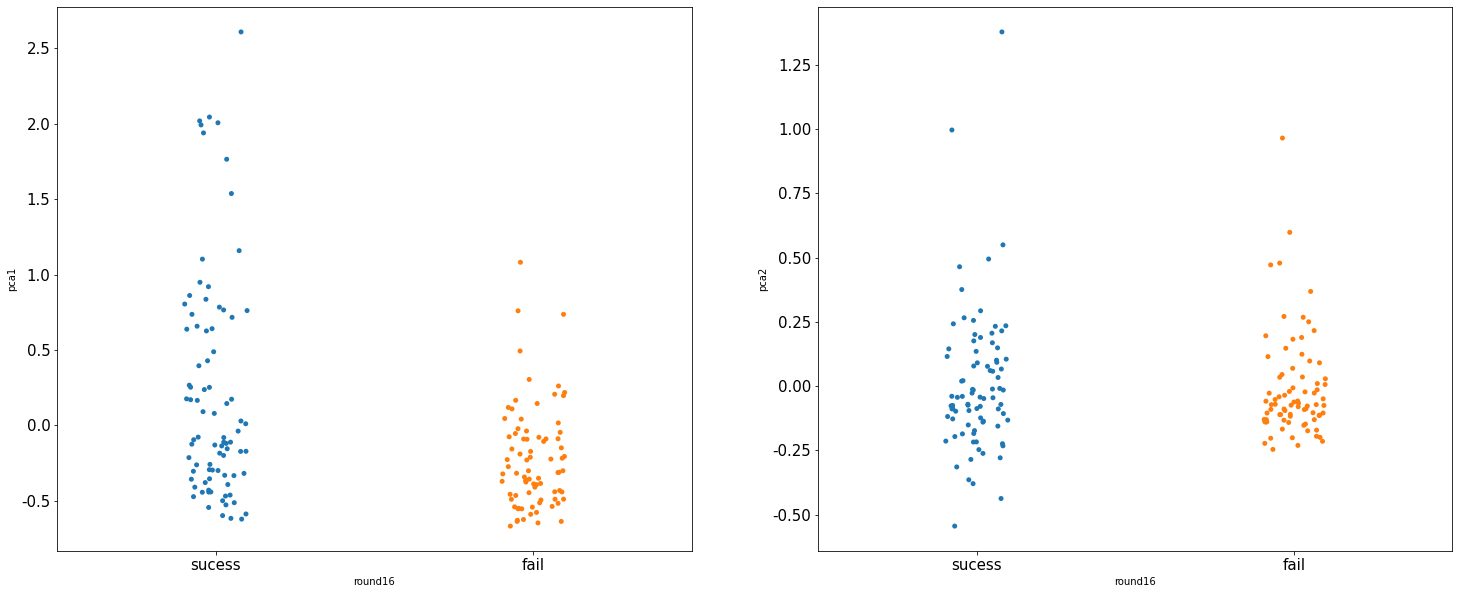

In [80]:
plt.subplot(1,2,1)
sns.stripplot(x="round16", y="pca1", data=result, jitter=True)

plt.subplot(1, 2, 2)
sns.stripplot(x="round16", y="pca2", data=result, jitter=True)
plt.show()

In [118]:
result.to_csv('MF_pca.csv', index=False, encoding='utf-8')